### Imports and Set Up

In [1]:
import scanpy as sc
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer,LabelBinarizer
from sklearn.metrics import f1_score 
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import functions as fun 
import modelCROSSATTN

In [2]:
sc.settings.verbosity
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

### Prepping Data

##### expression profile

In [3]:
adata =  sc.read_h5ad("data/Norman_2019.h5ad")  # replace with your path

#export data from sc.read
ddata = adata.X.toarray()
labels = adata.obs['perturbation_name'].to_numpy()

parsed_labels = [p.split('+') if p != 'control' else [] for p in labels]
mlb = MultiLabelBinarizer()
labels_int = mlb.fit_transform(parsed_labels)

'''LB = LabelBinarizer()
labels_int = LB.fit_transform(labels)'''

'LB = LabelBinarizer()\nlabels_int = LB.fit_transform(labels)'

##### creating positional encoding

In [4]:
final_positional_encoding = fun.create_positional_embedding(adata)
masks = fun.create_masks(adata)


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/steveyin/Library/Caches/pyensembl/GRCh38/ensembl109/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/steveyin/Library/Caches/pyensembl/GRCh38/ensembl109/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/steveyin/Library/Caches/pyensembl/GRCh38/ensembl109/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
100%|██████████| 111255/111255 [00:00<00:00, 314083.49it/s]


SUCCESS: Final matrix generated with shape (111255, 24)


In [ ]:
control_mask = adata.obs['perturbation_name'] == "control"
double_mask = adata.obs['perturbation_name'].str.contains("+",regex=False)
single_mask = ~(control_mask | double_mask)
controls = adata[control_mask]

##### Prepping Model

In [5]:
train_dataset,test_dataset = fun.split_data(adata,final_positional_encoding, 
                                            masks, 
                                            labels_int)

Train cells: 99017  |  Test cells: 12238
Train perturbations: 197  |  Test perturbations: 40
Overlap between train/test perturbations: []


In [6]:
    # --- Create DataLoaders ---
batch_size = 32 # You might need to adjust this based on GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # --- Define Hyperparameters and Instantiate Model ---
model = modelCROSSATTN.MultiModalCrossAttentionModel(
    n_genes=adata.n_vars,
    n_positional_features=final_positional_encoding.shape[1],
    n_classes=labels_int.shape[1],
    embed_dim=136,
    n_heads=8,
    dropout=0.3
)
    
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 65

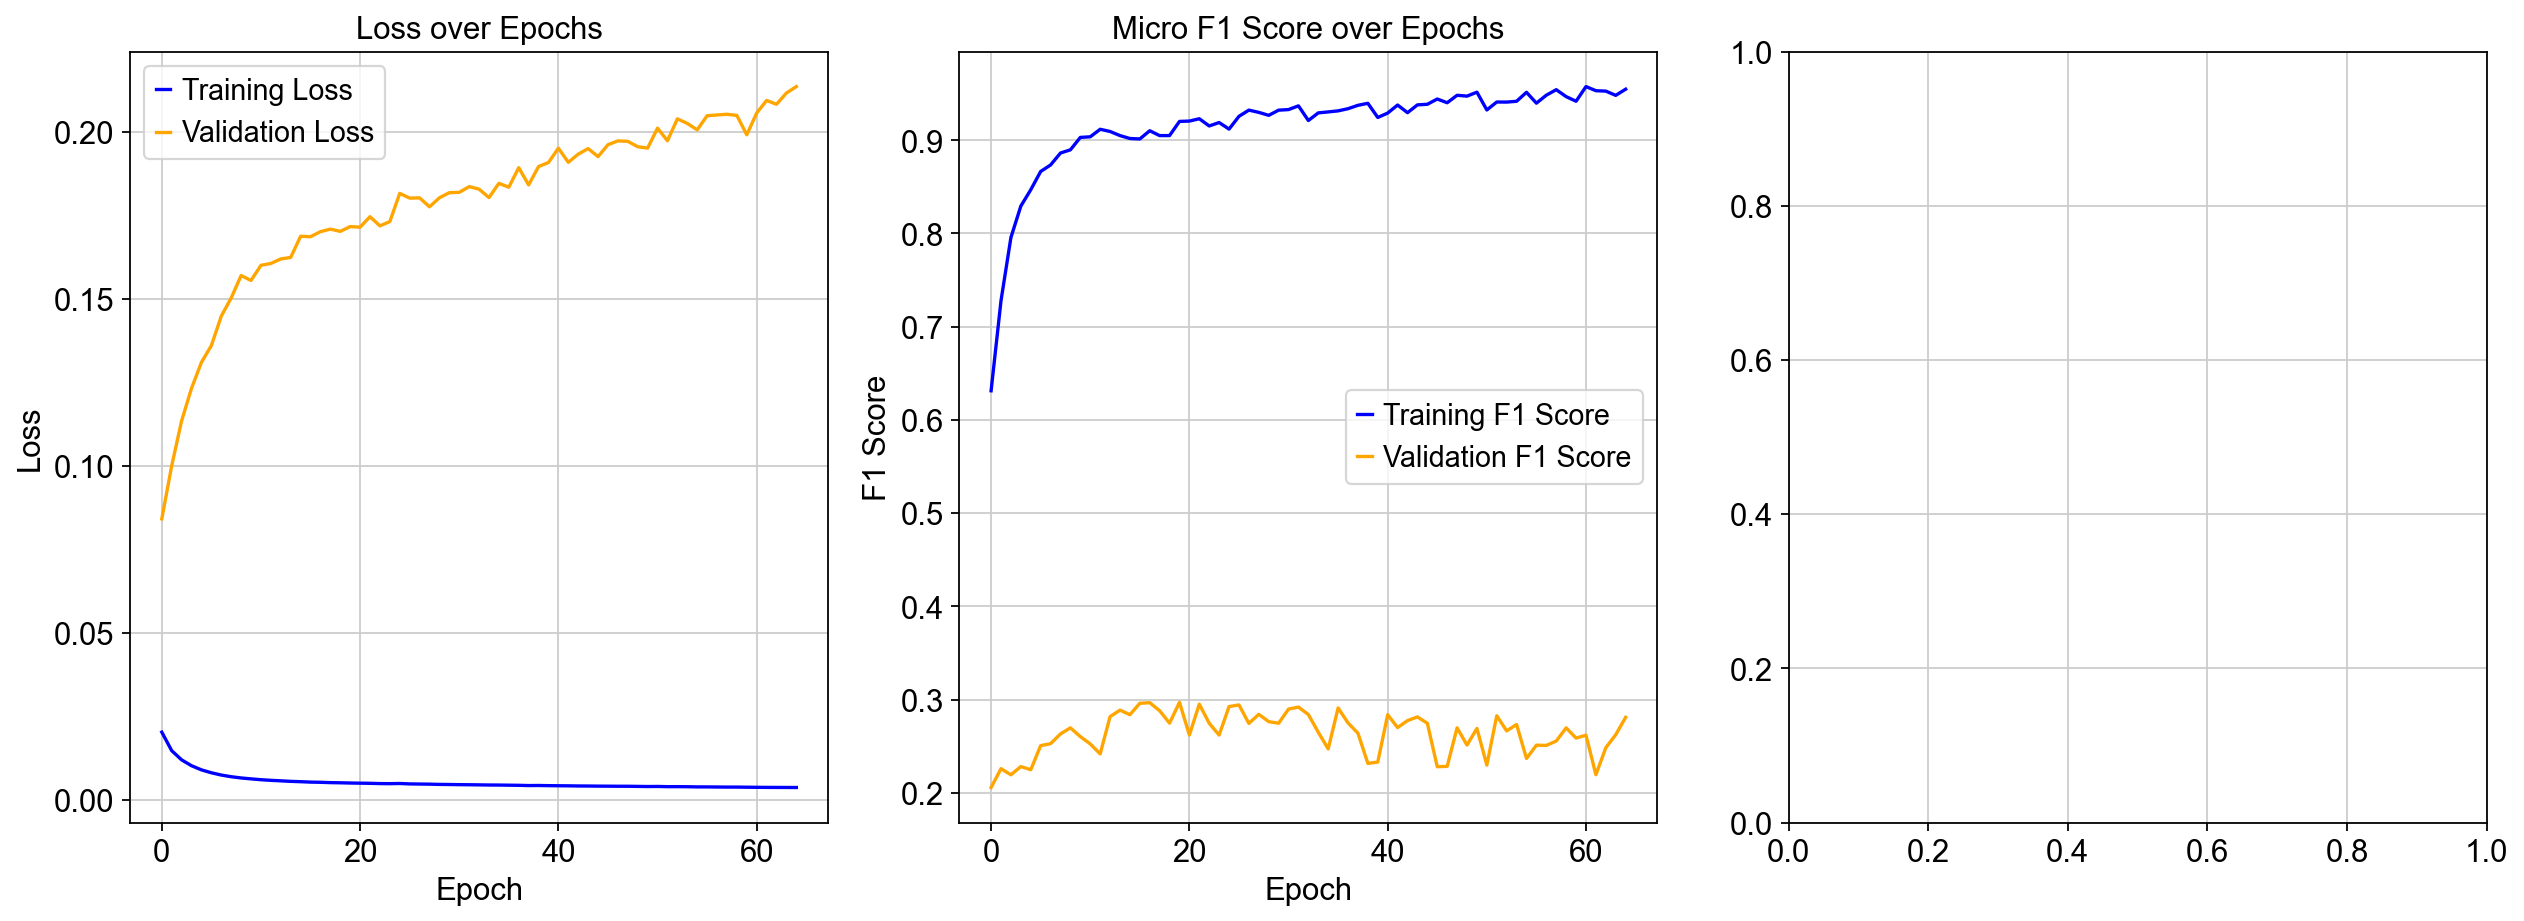

Epoch 65/65 | Train Loss: 0.0037 | Val Loss: 0.2135 | Train F1: 0.9547 | Val F1: 0.2809 

Training Complete. Final Validation F1 Score: 0.2809


In [8]:
modelCROSSATTN.train(model, train_loader,test_loader,optimizer,criterion, num_epochs)

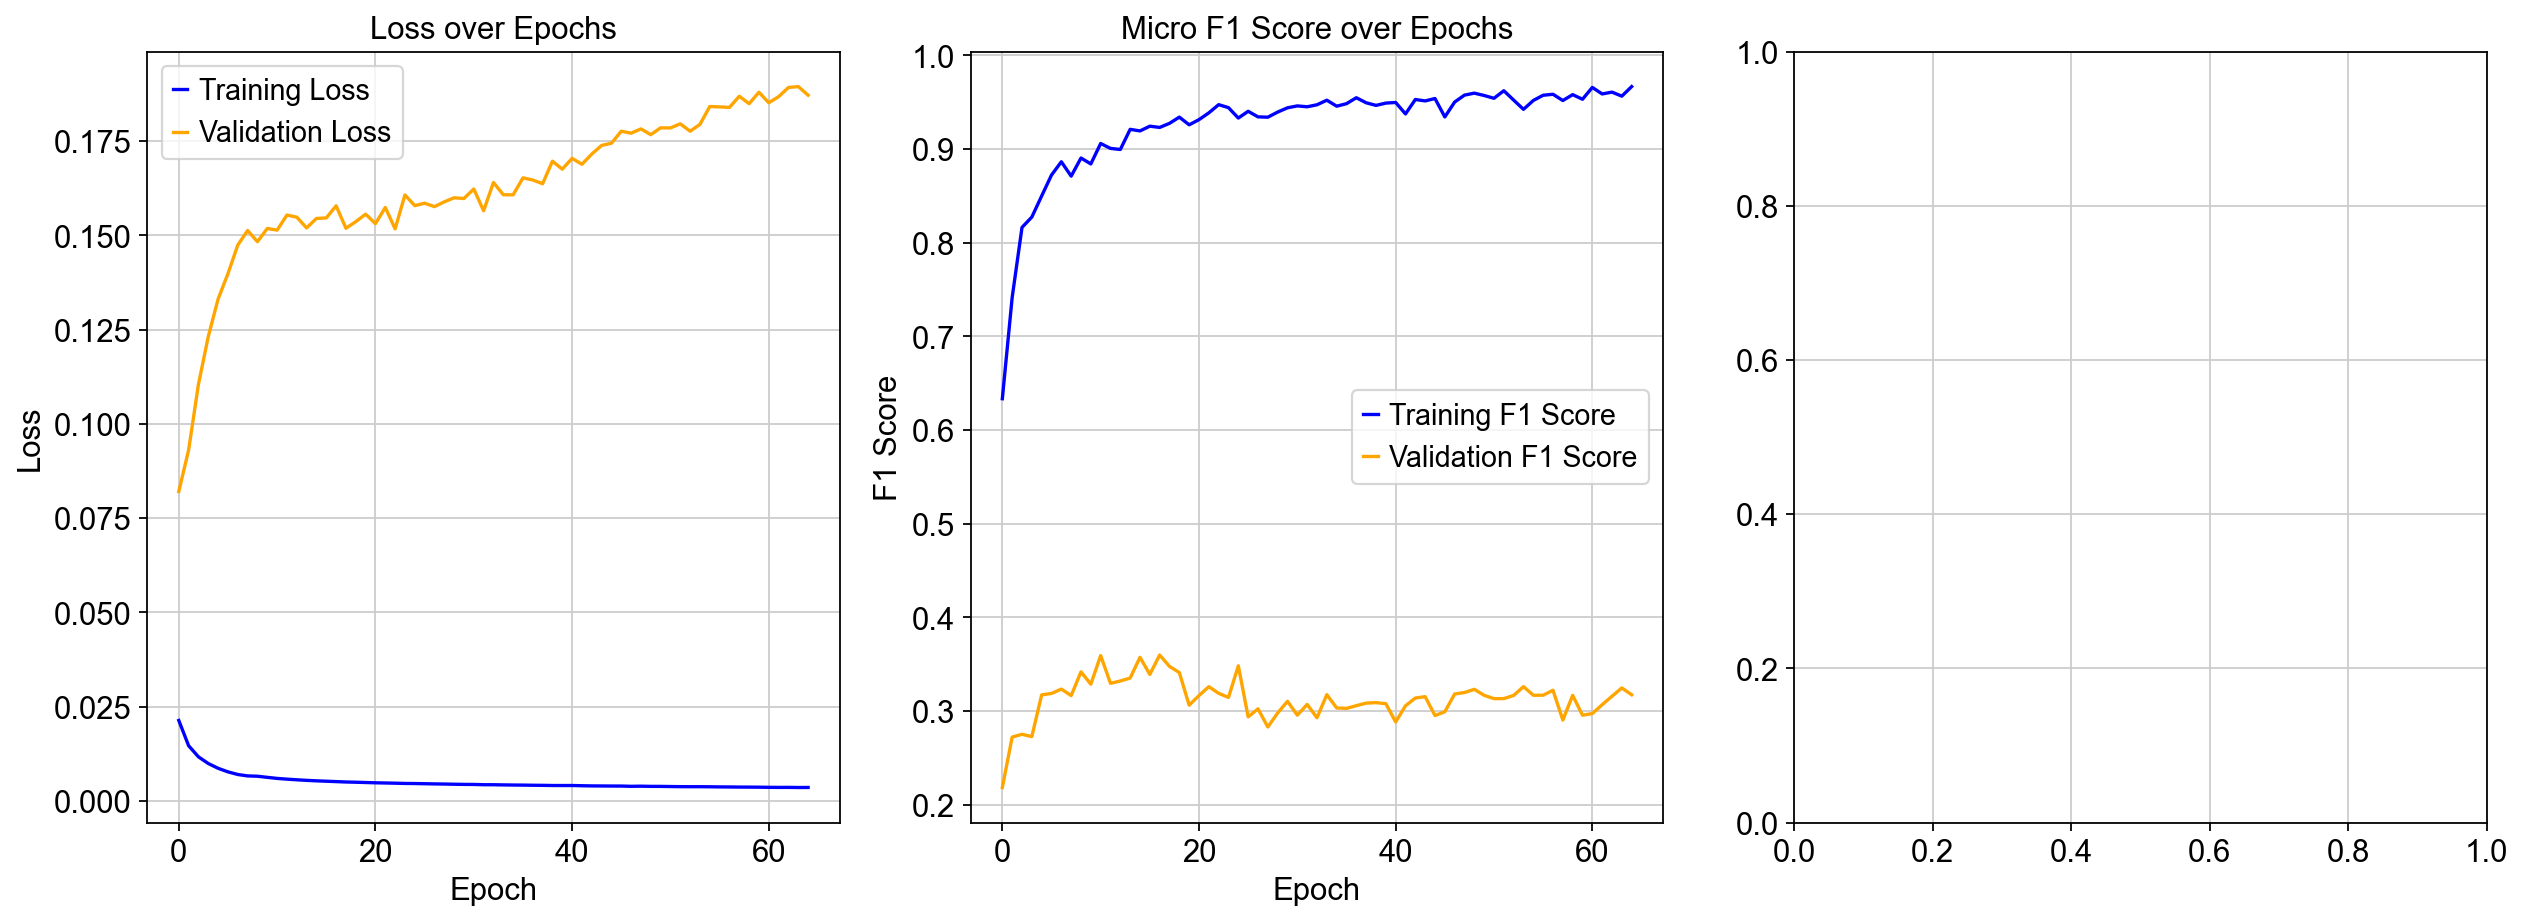

Epoch 65/65 | Train Loss: 0.0036 | Val Loss: 0.1872 | Train F1: 0.9666 | Val F1: 0.3172 

Training Complete. Final Validation F1 Score: 0.3172


In [ ]:
from IPython.display import display, clear_output


# --- 1. Initialization for Plotting ---
# Create lists to store the history of metrics
train_losses,val_losses = [],[]
train_f1_scores,val_f1_scores = [], []
all_acc1_scores, all_acc5_scores = [],[]

# Create a figure and axes for the plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
# Initially display the empty figure
display(fig)

print("\nStarting training with live plotting...")
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0
    # Use tqdm for a progress bar on the training data
    for (expression, position), labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
        optimizer.zero_grad()
        # The model's forward pass now takes two inputs
        outputs = model(expression, position)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Evaluation Phase ---
    model.eval()
    all_val_preds, all_val_labels = [], []
    all_train_preds, all_train_labels = [], []
    all_acc1, all_acc5 = [],[]
    total_val_loss = 0
    
    with torch.no_grad():
        # Get validation metrics
        for (expression, position), labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
            outputs = model(expression, position)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_val_preds.append(preds.cpu().numpy())
            all_val_labels.append(labels.cpu().numpy())

            '''if labels.dim() == 2:
                labels = labels.argmax(dim=1)

            acc1 = topk_accuracy(outputs,labels, k=1)
            acc5 = topk_accuracy(outputs,labels, k=5)
            
            all_acc1.append(acc1)
            all_acc5.append(acc5)'''


        # Also get training metrics for comparison (important for diagnosing overfitting)
        for (expression, position), labels in train_loader:
            outputs = model(expression, position)

            '''if labels.dim() == 2:
                labels = labels.argmax(dim=1)
            '''
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_train_preds.append(preds.cpu().numpy())
            all_train_labels.append(labels.cpu().numpy())



    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)


    train_f1 = f1_score(np.vstack(all_train_labels), np.vstack(all_train_preds), average='micro')
    val_f1 = f1_score(np.vstack(all_val_labels), np.vstack(all_val_preds), average='micro')

    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)
    '''all_acc1_scores.append(acc1)
    all_acc5_scores.append(acc5)'''

    plot(fig, ax1, ax2, ax3, train_losses, val_losses, train_f1_scores, val_f1_scores)

    # Print a summary for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs} | "
      f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
      f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f} ")

# --- 3. Cleanup after the loop is done ---
plt.close(fig)
print(f"\nTraining Complete. Final Validation F1 Score: {val_f1_scores[-1]:.4f}")